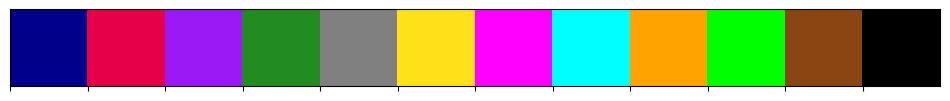

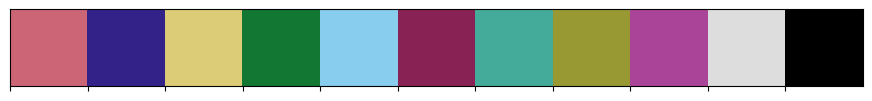

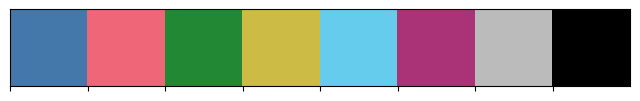

In [1]:
from glob import glob
import itertools
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl

from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import TITLE_STYLES as TS
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import PAUL_TOL_MUTED as PTM
from polyphys.visualize.plotter import PAUL_TOL_BRIGHT as PTB

from polyphys.visualize import tuner
from polyphys.manage import organizer
from polyphys.probe import logger
from polyphys.manage import utilizer 
from polyphys.manage.parser import TwoMonDep
from polyphys.analyze import clusters
from polyphys.analyze import measurer
import warnings
warnings.filterwarnings("ignore")
#database = '../../Datasets/'
database = '/Users/amirhsi_mini/research_data/analysis/'
#save_to_data = '/Users/amirhsi/Library/CloudStorage/OneDrive-UniversityofWaterloo/PhD_Research/Jupyter/datasets/'
save_to_data = '/Users/amirhsi/Library/CloudStorage/OneDrive-UniversityofWaterloo/PhD_Research/Jupyter/datasets/TwoMonDep-allInOne/'
save_to_fig = '/Users/amirhsi/Library/CloudStorage/OneDrive-UniversityofWaterloo/PhD_Research/Jupyter/test_plots/TwoMonDep/'
sns.palplot(AC)
sns.palplot(PTM)
sns.palplot(PTB)

## Extract dataset for the first time

In [2]:
project = 'TwoMonDep'

log_details = {
    'TwoMonDep': {
        'space_pat': 'nm*am*ac*nc*',
        'hierarchy': '/am*.log',  # dir/file
        'parser': TwoMonDep,
        'lineage': 'whole',
        'geometry': 'cubic',
        'group': 'bug',
        'topology': 'atom',
        'product_idx': 1
    }
}
#log_db = "/Users/amirhsi_mini/OneDrive - University of Waterloo/PhD Research/Jupyter/Datasets/logs/"
#log_db = '/Users/amirhsi_mini/research_data/TransFociCub/logs/'
log_db = '/Users/amirhsi/research_data/'+project+'-logs/'
space_dbs = glob(log_db + log_details[project]['space_pat'] + '-logs')
space_dbs.sort()

In [3]:
thermos = []
#run_stats = []
#wall_times = []
for space_db in space_dbs:
    print(space_db)
    space = space_db.split("/")[-1]
    logs = glob(space_db + log_details[project]['hierarchy'])
    logs = organizer.sort_filenames(logs,  fmts=['.log']) # sorted
    logs = [log[0] for log in logs]
    for log in logs:
        print(log)
        log_info = log_details[project]['parser'](
            log,
            log_details[project]['lineage'],
            log_details[project]['geometry'],
            log_details[project]['group'],
            log_details[project]['topology']
        )
        lineage = log_details[project]['lineage']
        # handling product_idx in segmented logs:
        if lineage == 'segment' and log_info.segment_id>1:
            product_idx = 0
        # handling product_idx in restart logs which do not have product phase
        if  not (log.endswith('restart.log') | log.endswith('restart2ndRound.log')):
            product_idx = log_details[project]['product_idx']
        else:
            product_idx = 0
        try:
            log_data = logger.LammpsLog(log, product_idx)
        except (logger.BrokenLogError, IndexError):
            print("broken log: ", log_info.filepath.split("/")[-1])
        log_data.extract_thermo()
        #log_data.extract_run_stat()
        thermo = log_data.thermo
        #run_stat = log_data.run_stat
        #wall_time = log_data.wall_time
        for attr_name in log_info._lineage_attributes[lineage].keys():
            attr_value = getattr(log_info, attr_name)
            thermo[attr_name] = attr_value
        attr_names = ['phi_m_bulk', 'rho_m_bulk', 'phi_c_bulk', 'rho_c_bulk']
        for attr_name in attr_names:
            attr_value = getattr(log_info, attr_name)
            thermo[attr_name] = attr_value
        for lineage_name in log_info.genealogy:
            attr_value = getattr(log_info, lineage_name)
            thermo[lineage_name] = attr_value
            #run_stat[lineage_name] = attr_value
            #wall_time[lineage_name] = attr_value
        thermos.append(thermo)
        #run_stats.append(run_stat)
        #wall_times.append(wall_time)

output = "-".join(["allInOne", project, "thermos"])
thermos = pd.concat(thermos)
thermos.drop_duplicates(inplace=True)
thermos.reset_index(inplace=True, drop=True)
thermos.to_parquet(
    save_to_data + output + ".parquet.brotli", index=False, compression='brotli'
)
output = "-".join(["allInOne", project, "runStat"])
#run_stats = pd.concat(run_stats)
#run_stats.reset_index(inplace=True, drop=True)
#run_stats.to_csv(save_to_data + output + ".csv", index=False)
#output = "-".join(["allInOne", project, "wallTimeStat"])
#wall_times = pd.concat(wall_times)
#wall_times.reset_index(inplace=True, drop=True)
#wall_times.to_csv(save_to_data + output + ".csv", index=False)

/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.0dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.1dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.2dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.3dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.4dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.0nm2ac1.0nc8953hl12.5sd0.5dt0.0005bdump2000adump5000tdump5000ens1.log
/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs/am5.

## Working with dataset

In [2]:
def pot_LJ(r: float, sig: float = 1, eps: float = 1) -> float:
    """
    Calculate the Lennard-Jones potential for a given distance.

    The Lennard-Jones potential is a mathematical model that approximates the interaction 
    between a pair of neutral atoms or molecules. It is widely used in physics and chemistry 
    to describe the potential energy of interactions between particles.

    Parameters
    ----------
    r : float
        The distance between two interacting particles. It must be greater than zero 
        to avoid division by zero.
    
    sig : float, optional (default=1)
        The distance at which the potential between two particles is zero. It is also 
        known as the "collision diameter" or "finite size" parameter.
    
    eps : float, optional (default=1)
        The depth of the potential well, representing the strength of the attraction 
        between the particles.

    Returns
    -------
    float
        The Lennard-Jones potential energy at distance `r`.

    Notes
    -----
    The potential is calculated using the formula:
    
        U(r) = 4 * eps * [(sig/r)^12 - (sig/r)^6]
    
    In this function, the powers of `(sig/r)` are optimized by using repeated 
    multiplication rather than exponentiation to improve performance.
    
    The intermediate values calculated are:
    - `sr_ratio`: The ratio between `sig` and `r`.
    - `sr_ratio2`: The square of `sr_ratio`, i.e., `(sig/r)^2`.
    - `sr_ratio6`: The sixth power of `sr_ratio`, i.e., `(sig/r)^6`.
    
    The final potential is computed as:
    
        pot = 4 * eps * (sr_ratio6^2 - sr_ratio6)
    
    This approach avoids the use of exponentiation (`**`) in favor of 
    multiplication for better performance.
    
    Examples
    --------
    >>> pot_LJ(2.0)
    -0.0615234375
    
    >>> pot_LJ(2.0, sig=0.8, eps=0.5)
    -0.0146484375

    """
    sr_ratio = sig / r
    sr_ratio2 = sr_ratio * sr_ratio
    sr_ratio6 = sr_ratio2 * sr_ratio2 * sr_ratio2  # Equivalent to (sig/r)^6
    pot = 4 * eps * (sr_ratio6 * sr_ratio6 - sr_ratio6)
    return pot


def pot_LJT(r: float, r_cut: float, sig: float, eps: float) -> float:
    """
    Calculate the truncated Lennard-Jones potential for a given distance.

    The truncated Lennard-Jones potential is commonly used to model interactions between 
    particles where the potential is considered only up to a specified cutoff distance. 
    Beyond this distance, the potential is set to zero to save computation and model 
    finite interaction ranges.

    Parameters
    ----------
    r : float
        The distance between two interacting particles. It must be greater than zero 
        to avoid division by zero.
    
    r_cut : float
        The cutoff distance beyond which the potential is set to zero. It defines the 
        range of interaction between the particles.
    
    sig : float
        The distance at which the potential between two particles is zero. It is also 
        known as the "collision diameter" or "finite size" parameter.
    
    eps : float
        The depth of the potential well, representing the strength of the attraction 
        between the particles.

    Returns
    -------
    float
        The truncated Lennard-Jones potential energy at distance `r`. If `r > r_cut`, 
        the potential is zero.

    Notes
    -----
    This function uses the Lennard-Jones potential formula only for distances less 
    than or equal to `r_cut`:

        U(r) = 4 * eps * [(sig/r)^12 - (sig/r)^6] for r <= r_cut

    Otherwise, the potential is set to zero.
    
    The `pot_LJ` function is optimized for better performance by avoiding the use of 
    exponentiation (`**`) and replacing it with multiplications.

    Examples
    --------
    >>> pot_LJ_cut(2.0, 3.0, sig=1.0, eps=1.0)
    -0.0615234375
    
    >>> pot_LJ_cut(3.5, 3.0, sig=1.0, eps=1.0)
    0

    """
    # Only calculate potential if r is within the cutoff distance
    if r <= r_cut:
        sr_ratio = sig / r
        sr_ratio2 = sr_ratio * sr_ratio
        sr_ratio6 = sr_ratio2 * sr_ratio2 * sr_ratio2  # (sig/r)^6
        return 4 * eps * (sr_ratio6 * sr_ratio6 - sr_ratio6)  # Lennard-Jones potential
    else:
        return 0


def pot_LJTS(r: float, r_cut: float, sig: float, eps: float) -> float:
    """
    Calculate the truncated and shifted Lennard-Jones potential for a given distance.

    The truncated and shifted Lennard-Jones potential is used to model interactions 
    between particles with a finite range while ensuring that the potential smoothly 
    goes to zero at the cutoff distance. This approach enhances the stability of 
    molecular dynamics simulations by avoiding discontinuities in the potential energy.

    Parameters
    ----------
    r : float
        The distance between two interacting particles. It must be greater than zero 
        to avoid division by zero.
    
    r_cut : float
        The cutoff distance beyond which the potential is set to zero. It defines the 
        interaction range between particles, and the potential is shifted to be zero at 
        `r_cut`.
    
    sig : float
        The distance at which the potential between two particles is zero. It is also 
        known as the "collision diameter" or "finite size" parameter.
    
    eps : float
        The depth of the potential well, representing the strength of the attraction 
        between the particles.

    Returns
    -------
    float
        The truncated and shifted Lennard-Jones potential energy at distance `r`. 
        If `r > r_cut`, the potential is zero.

    Notes
    -----
    The potential is calculated as follows:
    
        U(r) = 4 * eps * [(sig/r)^12 - (sig/r)^6] - U(r_cut) for r <= r_cut
        U(r) = 0 for r > r_cut
    
    where `U(r_cut)` is the value of the Lennard-Jones potential at the cutoff 
    distance. This ensures the potential is zero at `r_cut`.

    Examples
    --------
    >>> pot_LJ_truncated_shifted(2.0, 3.0, sig=1.0, eps=1.0)
    -0.0613555908203125
    
    >>> pot_LJ_truncated_shifted(3.5, 3.0, sig=1.0, eps=1.0)
    0

    """
    # Only calculate potential if r is within the cutoff distance
    if r <= r_cut:
        sr_ratio = sig / r
        sr_ratio2 = sr_ratio * sr_ratio
        sr_ratio6 = sr_ratio2 * sr_ratio2 * sr_ratio2  # (sig/r)^6
        lj_potential = 4 * eps * (sr_ratio6 * sr_ratio6 - sr_ratio6)  # LJ potential at r
        
        # Calculate potential at r_cut for shifting
        sr_cut_ratio = sig / r_cut
        sr_cut_ratio2 = sr_cut_ratio * sr_cut_ratio
        sr_cut_ratio6 = sr_cut_ratio2 * sr_cut_ratio2 * sr_cut_ratio2  # (sig/r_cut)^6
        lj_potential_cut = 4 * eps * (sr_cut_ratio6 * sr_cut_ratio6 - sr_cut_ratio6)  # LJ potential at r_cut
        
        return lj_potential - lj_potential_cut
    else:
        return 0

In [4]:
project = 'TwoMonDep'
file_name = "-".join(["allInOne", project, "thermos.parquet.brotli"])
thermos = pd.read_parquet(save_to_data + file_name)
thermos.columns

Index(['Step', 'Temp', 'Press', 'TotEng', 'PotEng', 'KinEng', 'E_pair',
       'E_vdwl', 'Ecouple', 'Econserve', 'e_spr', 'fx_spr', 'fy_spr', 'fz_spr',
       'fmag_spr', 'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c',
       'fx_m2_c', 'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2', 'fy_m1_m2',
       'fz_m1_m2', 'nmon', 'dmon', 'lcube', 'dcrowd', 'ncrowd', 'd_sur', 'dt',
       'bdump', 'adump', 'tdump', 'ensemble_id', 'phi_m_bulk', 'rho_m_bulk',
       'phi_c_bulk', 'rho_c_bulk', 'lineage_name', 'whole', 'ensemble_long',
       'ensemble', 'space'],
      dtype='object')

In [14]:
extensive_quants_fix_spring_self = ['e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c', 
                    'fx_m2_c', 'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2',
                    'fy_m1_m2', 'fz_m1_m2']

extensive_quants = ['e_spr', 'fx_spr', 'fy_spr', 'fz_spr',
       'fmag_spr', 'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c',
       'fx_m2_c', 'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2', 'fy_m1_m2',
       'fz_m1_m2']

for col in extensive_quants:
    thermos[col] = thermos[col] * (thermos['ncrowd'] + 1) # 1 is for the monomer

sigma = 1
thermos['r'] = (thermos['d_sur'] + thermos['dmon'])
thermos['r_cut'] = thermos['dmon'] * round(2**(1/6), 6)
# Computing LJ truncated and shifted potential for each row
thermos['pot_ljts'] = thermos.apply(lambda row: pot_LJTS(row['r'], row['r_cut'], row['dmon'], sigma), axis=1)

thermos['e_spr_ljts'] = thermos['e_spr'] - thermos['pot_ljts']

thermos['f_m1_c'] = (thermos['fx_m1_c']**2 + thermos['fy_m1_c']**2 + thermos['fz_m1_c']**2)**0.5 
thermos['f_m2_c'] = (thermos['fx_m2_c']**2 + thermos['fy_m2_c']**2 + thermos['fz_m2_c']**2)**0.5
thermos['f_m1_m2'] = (thermos['fx_m1_m2']**2 + thermos['fy_m1_m2']**2 + thermos['fz_m1_m2']**2)**0.5

thermos['fx_dep'] = (thermos['fx_m1_c'] - thermos['fx_m2_c']) / 2
thermos['fy_dep'] = (thermos['fy_m1_c'] - thermos['fy_m2_c']) / 2
thermos['fz_dep'] = (thermos['fz_m1_c'] - thermos['fz_m2_c']) / 2
thermos['e_dep_avg_ljts'] = thermos['e_m1_c'] + thermos['e_m2_c'] - thermos['pot_ljts']
thermos['e_dep_avg_m1_m2'] = thermos['e_m1_c'] + thermos['e_m2_c'] - thermos['e_m1_m2']
thermos['e_dep_avg_m1_m2_ljts'] = thermos['e_m1_c'] + thermos['e_m2_c'] - thermos['e_m1_m2'] - thermos['pot_ljts']
thermos['e_dep_avg'] = thermos['e_m1_c'] + thermos['e_m2_c']
thermos['e_dep_diff'] = thermos['e_m1_c'] - thermos['e_m2_c']

thermo_vars_fix_spring = ['Temp', 'Press', 'TotEng', 'PotEng', 'KinEng', 'E_pair',
       'E_vdwl', 'Ecouple', 'Econserve', 'f_e_spring_1', 'f_e_spring_2',
       'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c', 'fx_m2_c',
       'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2', 'fy_m1_m2', 'fz_m1_m2',
       'fx_dep', 'fy_dep', 'fz_dep', 'e_dep_avg', 'e_dep_diff',
       'f_m1_c', 'f_m2_c', 'f_m1_m2', 'pot_ljts', 'e_dep_avg_ljts'
       ]
thermo_vars = ['Temp', 'Press', 'TotEng', 'PotEng', 'KinEng', 'E_pair',
       'E_vdwl', 'Ecouple', 'Econserve', 'e_spr', 'fx_spr', 'fy_spr', 'fz_spr',
       'fmag_spr', 'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c',
       'fx_m2_c', 'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2', 'fy_m1_m2',
       'fz_m1_m2', 'fx_dep', 'fy_dep', 'fz_dep', 'e_dep_avg', 'e_dep_diff',
       'f_m1_c', 'f_m2_c', 'f_m1_m2', 'pot_ljts', 'e_dep_avg_ljts', 'e_spr_ljts',
       'e_dep_avg_m1_m2', 'e_dep_avg_m1_m2_ljts'
       ]

id_vars = ['nmon', 'dmon', 'lcube', 'dcrowd', 'ncrowd', 'd_sur', 'dt', 'bdump',
        'adump', 'tdump', 'ensemble_id', 'phi_m_bulk', 'rho_m_bulk',
       'phi_c_bulk', 'rho_c_bulk', 'lineage_name', 'whole', 'ensemble_long',
       'ensemble', 'space']
thermos_avg = thermos.groupby(id_vars)[thermo_vars].agg(['mean', 'sem'])
thermos_avg.columns = thermos_avg.columns.to_flat_index()
new_cols = {col: '_'.join(col).strip('_') for col in thermos_avg.columns}
thermos_avg.rename(columns=new_cols, inplace=True)
thermos_avg
thermos_avg.reset_index(inplace=True)
thermos_avg_melt = pd.melt(thermos_avg, id_vars=id_vars, var_name="variable_stat", value_name='value')
# Separate the "variable_stat" into two columns: "variable" and "stat"
thermos_avg_melt[['variable', 'stat']] = thermos_avg_melt['variable_stat'].str.rsplit('_', n=1, expand=True)
# Drop the original combined column
thermos_avg_melt.drop(columns=['variable_stat'], inplace=True)
# Pivot t o get the desired structure: one column for 'mean' and one for 'var'
thermos_avg_final = thermos_avg_melt.pivot_table(
    index=id_vars + ['variable'],  # Use id_vars and variable as the index
    columns='stat',  # The 'stat' (mean/var) becomes the columns
    values='value'  # Values for mean and var
)
thermos_avg_final.reset_index(inplace=True)

In [33]:
y_labels_and_titles = {
    'e_spr': (r"$U_{\text{s}}(r)/ \epsilon$", r"$U_{\text{s}}(r)$: Spring energy keeping two monomers at distance $r$."),
    'e_spr_ljts': (r"$E_{\text{dep}}(r)/ \epsilon$", r"Depletion energy: $E_{\text{dep}}(r)=U_{\text{s}}(r)- U_{\text{WCA}}(r)$"),
    'fx_spr': (r"$F_{\text{s},x}a_c/ \epsilon$", "Constraining harmonic force: x direction"),
    'fy_spr': (r"$F_{\text{s},y}a_c/ \epsilon$", "Constraining harmonic force: y direction"),
    'fz_spr': (r"$F_{\text{s},z}a_c/ \epsilon$", "Constraining harmonic force: z direction"),
    'fmag_spr': (r"$F_{\text{spr}}a_c/ \epsilon$", "Constraining harmonic force: magnitude"),
    'e_m1_c': (r"$E_{A,c}(r)/ \epsilon$", r"$E_{A,c}(r)$: Total interaction energy between monomer A and crowders at distance $r$ between monomers"),
    'f_m1_c': (r"$F_{A,c}a_c / \epsilon$", "Monomer A: Crowders"),
    'fx_m1_c': (r"$f_{A,c,x}a_c / \epsilon$", "Monomer A: Crowders"),
    'fy_m1_c': (r"$f_{A,c,y}a_c / \epsilon$", "Monomer A: Crowders"),
    'fz_m1_c': (r"$f_{A,c,z}a_c / \epsilon$", "Monomer A: Crowders"),
    'e_m2_c': (r"$E_{B,c}(r)/ \epsilon$", r"$E_{B,c}(r)$: Total interaction energy between monomer B and crowders at distance $r$ between monomers"),
    'f_m2_c': (r"$F_{B,c}a_c / \epsilon$", "Monomer B: Crowders"),
    'fx_m2_c': (r"$f_{B,c,x}a_c / \epsilon$", "Monomer B: Crowders"),
    'fy_m2_c': (r"$f_{B,c,y}a_c / \epsilon$", "Monomer B: Crowders"),
    'fz_m2_c': (r"$f_{B,c,z}a_c / \epsilon$", "Monomer B: Crowders"),
    'e_m1_m2': (r"$E_{A,B}(r)/ \epsilon$", r"$E_{A,B}(r)$: Total interaction energy between monomers A and B at distance $r$ between them"),
    'f_m1_m2': (r"$F_{A,B}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fx_m1_m2': (r"$f_{A,B,x}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fy_m1_m2': (r"$f_{A,B,y}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fz_m1_m2': (r"$f_{A,B,z}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fx_dep': (r"$F_{\text{dep},x}a_c / \epsilon$", r"$F_{\text{dep},x}=\frac{1}{2}\langle \sum_c (f_{Ac,x}-f_{Bc,x}) \rangle$"),
    'fy_dep': (r"$F_{\text{dep},y}a_c / \epsilon$", r"$F_{\text{dep},y}=\frac{1}{2}\langle \sum_c (f_{Ac,y}-f_{Bc,y} \rangle$"),
    'fz_dep': (r"$F_{\text{dep},z}a_c / \epsilon$", r"$F_{\text{dep},z}=\frac{1}{2}\langle \sum_c (f_{Ac,z}-f_{Bc,z}) \rangle$"),
    'e_dep_avg': (r"$E_{\text{dep}}/ \epsilon$", r"Depletion Energy: $E_{\text{dep}}(r)=U_{A,c}(r)+U_{B,c}(r)$"),
    'e_dep_avg_m1_m2': (r"$E_{\text{dep}}(r)/ \epsilon$", r"Depletion Energy: $E_{\text{dep}}(r)=U_{A,c}(r)+U_{B,c}(r)-U_{A,B}(r)$"),
    'e_dep_avg_ljts': (r"$E_{\text{dep}}(r)/ \epsilon$", r"Depletion Energy: $E_{\text{dep}}(r)=U_{A,c}(r)+U_{B,c}(r)-U_{\text{WCA}}(r)$"),
    'e_dep_avg_m1_m2_ljts': (r"$E_{\text{dep}}(r)/ \epsilon$", r"Depletion Energy: $E_{\text{dep}}(r)=U_{A,c}(r)+U_{B,c}(r)-U_{A,B}(r)-U_{\text{WCA}}(r)$"),
    'e_dep_diff': (r"$E_{\text{dep, diff}}(r)/ \epsilon$", "Differential Depletion Energy"),
    'pot_ljts': (r"$U_{\text{WCA}}(r)/ \epsilon$", r"$U_{\text{WCA}}(r)$: WCA potential between monomomers A and B at distance $r$")
}

In [14]:
for thermo_var in thermo_vars:
    grid = sns.relplot(
        data=thermos,
        x='Step',
        y=thermo_var,
        col='d_sur',
        col_wrap=7,
        kind='line', 
    )
    grid.tight_layout()
    grid.figure.savefig(save_to_fig+f"time_series-d_sur_as_col-{thermo_var}.pdf")
    plt.close()

In [30]:
# Property to plot (mean or sem)
y_property = 'mean'
# Columns representing energy (e) and force (f) components in the system
selected_columns = [
    'e_m1_c', 'e_m2_c', #'e_m1_m2', 
    #'f_m1_c', 'f_m2_c', 'f_m1_m2', # Total forces
    'fx_m1_c', 'fy_m1_c', 'fz_m1_c',  # Monomer A to crowders
    'fx_m2_c', 'fy_m2_c', 'fz_m2_c',  # Monomer B to crowders
    'pot_ljts',
    #'fx_m1_m2', 'fy_m1_m2', 'fz_m1_m2',  # Monomer A to Monomer B
    'fx_dep', 'fy_dep', 'fz_dep',  # Depletion forces
    #'e_dep_avg', 'e_dep_diff'  # Average and differential depletion energy
]
# Filter the data for the selected variables (forces and energies)
plot_data = thermos_avg_final.loc[
    thermos_avg_final['variable'].isin(selected_columns),
    ['d_sur', 'mean', 'sem', 'variable']
]

# Create a line plot for each variable in selected_columns
grid = sns.relplot(
    data=plot_data,
    x='d_sur',
    y=y_property,
    col='variable',
    col_order=selected_columns,
    col_wrap=3,
    kind='line',
    marker='s',
    facet_kws={'sharey': False, 'sharex': False}  # Allow separate x and y scales for each facet
)

# Loop through each subplot to set the y-axis labels and titles
# Loop through the subplots and set the y-axis labels and titles correctly
for variable, ax in grid.axes_dict.items():
    y_label, title = y_labels_and_titles[variable]
    ax.set_ylabel(y_label)  # Set y-axis label with LaTeX formatting
    ax.set_title(title)  # Set the subplot title

# Set x-axis label for all subplots
grid.set_xlabels(r"$(r - a_m) / a_c$")

# Adjust layout for better spacing
grid.tight_layout()

# Save the figure in PDF format
output_path = f"{save_to_fig}equilibrium_var_vs_d_sur-{y_property}.pdf"
grid.figure.savefig(output_path)

# Close the plot to free memory
plt.close()

In [8]:
# Property to plot (mean or sem)
y_property = 'mean'

# Columns representing energy (e) and force (f) components in the system
selected_columns = [
    'e_spr', 'e_spr_ljts', 'fx_spr', 'fy_spr', 'fz_spr', 'fmag_spr',
    'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c',  # Monomer A to crowders
    'e_m2_c', 'fx_m2_c', 'fy_m2_c', 'fz_m2_c',  # Monomer B to crowders
    'fx_dep', 'fy_dep', 'fz_dep', 'e_dep_avg_ljts',  # Depletion forces
    'pot_ljts', 'e_dep_avg', 'e_dep_diff'  # Average and differential depletion energy
]


# Filter the data for the selected variables (forces and energies)
plot_data = thermos_avg_final.loc[
    thermos_avg_final['variable'].isin(selected_columns),
    ['d_sur', 'mean', 'sem', 'variable']
]

# Create a line plot for each variable in selected_columns
grid = sns.relplot(
    data=plot_data,
    x='d_sur',
    y=y_property,
    col='variable',
    col_order=selected_columns,
    col_wrap=4,
    kind='line',
    marker='s',
    facet_kws={'sharey': False, 'sharex': False}  # Allow separate x and y scales for each facet
)

# Loop through each subplot to set the y-axis labels and titles
# Loop through the subplots and set the y-axis labels and titles correctly
for variable, ax in grid.axes_dict.items():
    y_label, title = y_labels_and_titles[variable]
    ax.set_ylabel(y_label)  # Set y-axis label with LaTeX formatting
    ax.set_title(title)  # Set the subplot title

# Set x-axis label for all subplots
grid.set_xlabels(r"$(r - a_m) / a_c$")
# Add legend below the entire figure
# Adjust space below the figure to fit the legend
grid.figure.subplots_adjust(bottom=0.5, left=0)
# Add legend below the entire figure
legend_text = "A: Monomer 1 | B: Monomer 2 | c: Crowders"
grid.figure.text(0.52, 0, legend_text, ha='center', fontsize=12)
# Adjust layout for better spacing
grid.tight_layout()

# Save the figure in PDF format
output_path = f"{save_to_fig}equilibrium_var_vs_d_sur-{y_property}.pdf"
grid.figure.savefig(output_path)

# Close the plot to free memory
plt.close()

In [ ]:
grid.axes_dict

In [34]:
# Property to plot (mean or sem)
y_property = 'mean'

# Columns representing energy (e) and force (f) components in the system
selected_columns = [
    'pot_ljts', 
    'e_spr', 
    'e_spr_ljts', 
    'e_m1_m2',
    'e_m1_c', 
    'e_m2_c',
    'e_dep_avg_ljts', 
    'e_dep_avg_m1_m2',  
    'e_dep_avg_m1_m2_ljts', 
]

# Filter the data for the selected variables (forces and energies)
plot_data = thermos_avg_final.loc[
    thermos_avg_final['variable'].isin(selected_columns),
    ['d_sur', 'mean', 'sem', 'variable']
]

# Create a line plot for each variable in selected_columns
grid = sns.relplot(
    data=plot_data,
    x='d_sur',
    y=y_property,
    col='variable',
    col_order=selected_columns,
    col_wrap=1,
    kind='line',
    marker='s',
    height=4,
    aspect=2*16/9,
    facet_kws={'sharey': False, 'sharex': False}  # Allow separate x and y scales for each facet
)

# Loop through each subplot to set the y-axis labels and titles
# Loop through the subplots and set the y-axis labels and titles correctly
for variable, ax in grid.axes_dict.items():
    y_label, title = y_labels_and_titles[variable]
    ax.set_ylabel(y_label)  # Set y-axis label with LaTeX formatting
    ax.set_title(title)  # Set the subplot title

# Set x-axis label for all subplots
grid.set_xlabels(r"$(r - a_m) / a_c$")
# Add legend below the entire figure
# Adjust space below the figure to fit the legend
grid.figure.subplots_adjust(bottom=0.5, left=0)
# Add legend below the entire figure
#legend_text = "A: Monomer 1 | B: Monomer 2 | c: Crowders"
#grid.figure.text(0.52, 0, legend_text, ha='center', fontsize=12)
# Adjust layout for better spacing
grid.tight_layout()

# Save the figure in PDF format
output_path = f"{save_to_fig}equilibrium_var_vs_d_sur-{y_property}.pdf"
grid.figure.savefig(output_path)

# Close the plot to free memory
plt.close()